In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import pickle
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, brier_score_loss 

In [3]:
alpha = 0.5
gamma = 1
seq_len = 1
learning_rate = 1e-4
batch_size = 256
max_epoch = 20
experiment_time = 1
limit_early_stop_count = 5
device = torch.device("cuda")

use_upsample = True
use_mini_sample = True

#task_name_list = ['dialysis','DNR']
#task_name_list = ['dod_7day','DNR']
#task_name_list = ['dod_30day','DNR']
#task_name_list = ['dod_90day','DNR']
#task_name_list = ['Weaning_successful','DNR']
#task_name_list = ['SBT','DNR']
#task_name_list = ['dod_30day']
#task_name_list = ['dod','dod_90day']
#task_name_list = ['dod_30day','dod_90day']
#task_name_list = ['dod']
#task_name_list = ['DNR']
#task_name_list = ['Vasopressor']
#task_name_list = ['InvasiveVent']
#task_name_list = ['dod_90day']

task_name_list = ['DNR','dod_30day','Vasopressor']

#task_name_list = ['DNR','dod_30day','Vasopressor','InvasiveVent','dialysis']


In [4]:
##++
class RNN_MTL(nn.Module):
    def __init__(self, input_dim, task_name_list,window_size = 3, dropout_ratio=0.0):
        super(RNN_MTL, self).__init__()

        self.dropout = nn.Dropout(dropout_ratio)
        self.relu = nn.ReLU()  # Activation function for hidden layers
        self.sigmoid = nn.Sigmoid()
        self.task_name_list = task_name_list
        self.num_tasks = len(task_name_list)
        hidden_dim = [256, 64]
        output_size = 1

        # Bottom
        self.bi_lstm = torch.nn.LSTM(input_dim, hidden_dim[0], num_layers=2, batch_first = True, bidirectional = True)
        #self.bt_fc1 = nn.Linear(input_dim, hidden_dim[0])
        #self.bt_fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        #self.bt_fc3 = nn.Linear(hidden_dim[1], hidden_dim[2])

        # Towers
        self.task_fc0 = nn.ModuleList([nn.Linear(hidden_dim[0]*window_size*2, hidden_dim[1]) for _ in range(self.num_tasks)])
        self.task_fc1 = nn.ModuleList([nn.Linear(hidden_dim[1], output_size) for _ in range(self.num_tasks)])
    
    def data_check(self,x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        #if x.ndim == 3:
        #    x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])  # Flatten 
        
        x = x.to(device)
        return x
    
    def forward(self, x):
        self.train() 
        x = self.data_check(x)
        
        h, _   = self.bi_lstm(x)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        # Towers
        task_out = {}
        for task_index in range(self.num_tasks):
            task_name = self.task_name_list[task_index]
            hi = self.task_fc0[task_index](h)
            hi = self.relu(hi)
            hi = self.dropout(hi)
            hi = self.task_fc1[task_index](hi)
            hi = self.sigmoid(hi)
            task_out[task_name] = hi    
            
        if len(self.task_name_list) == 1:
            return task_out[self.task_name_list[0]]
        else:
            return task_out
    
    def predict_prob(self, x):
        self.eval()
        prob_dict = self.forward(x)
        
        if len(self.task_name_list) == 1:
            prob_dict_true = {}
            prob_dict_true[self.task_name_list[0]] = prob_dict
            return prob_dict_true
        return prob_dict

    def predict_proba(self, x):
        self.eval()
        prob_dict = self.forward(x)
        
        if len(self.task_name_list) == 1:
            prob_dict_true = {}
            prob_dict_true[self.task_name_list[0]] = prob_dict
            return prob_dict_true
        
        return prob_dict
    
    def predict(self, x, threshold = 0.5):
        self.eval()
        prob_dict = self.predict_prob(x)
        pred_dict = {}
        
        for key, value in prob_dict.items():
            #tensor轉numpy
            value = value.cpu().detach().numpy()
            pred_class = [1 if x > threshold else 0 for x in value]
            pred_dict[key] = np.array(pred_class) 
        return pred_dict
    
    def evaluate(self,X,label,task_name,criterion):
        with torch.no_grad():
            prob = self.predict_prob(X)[task_name].cpu().detach().numpy() #tensor=>numpy
            pred = self.predict(X)[task_name] 
            score = compute_scores(label,pred,prob)
            score['task'] = task_name
            loss = criterion(torch.from_numpy(prob).to(device),torch.from_numpy(label).to(device)).item()
            score['loss'] = loss/len(label)
            return score
        
        

In [5]:
def compute_scores(y_true, y_pred,y_prob):
    if np.any(np.isnan(y_prob)):
        print(y_prob)
        input()
        
    scores = {}
    try:
        scores['task'] = 'Null'
        scores['auroc'] = round(roc_auc_score(y_true, y_prob), 3)
        scores['acc'] = round(accuracy_score(y_true, y_pred), 3)
        scores['f1'] = round(f1_score(y_true, y_pred), 3)
        scores['pre'] = round(precision_score(y_true, y_pred), 3)
        scores['recall'] = round(recall_score(y_true, y_pred), 3)
        scores['brier_score'] = round(brier_score_loss(y_true, y_prob), 3)
    except Exception as e:
        print("An error occurred:", str(e))
    
    return scores


In [6]:
"""
Input:
    model
    dict: Mydataset
    loss_function
Output:
    score: dict + dict
    result: dict => ['total_auc','total_loss']
"""
def test(model, dataset_dict, criterion, is_show = True):
    model.eval()

    task_name_list = list(dataset_dict.keys())
    score = {}
    result = {'total_auc': 0, 'total_loss': 0}
    for task_name in task_name_list:  # 循環每個任務
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
    
        score[task_name] = model.evaluate(X,Y,task_name,criterion)
        
        result['total_auc'] = result['total_auc'] + score[task_name]['auroc']
        result['total_loss'] = result['total_loss'] + score[task_name]['loss']
            
        if is_show:
            print(score[task_name])
    return score,result

"""
local_best_model_dict: #dict{'task_name':{'model','performance(target_score)','id'}}
model
"""
def test2(local_best_model_dict, dataset_dict, criterion, is_show = True):
    score = {}
    result = {'total_auc': 0, 'total_loss': 0}
    task_name_list = list(dataset_dict.keys())
    
    for task_name in task_name_list:
        #modelr.load_state_dict(local_best_model_dict[task_name]['model'])
        modelr = local_best_model_dict[task_name]['model']
        modelr.eval()
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        score[task_name] = modelr.evaluate(X,Y,task_name,criterion)
        result['total_auc'] = result['total_auc'] + score[task_name]['auroc']
        result['total_loss'] = result['total_loss'] + score[task_name]['loss']
        
        if is_show:
            print(score[task_name])
    print(X,Y)
    return score,result

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class MyDataset(Dataset):
    def __init__(self, np_X_scalar,np_X_original, np_Y):
        self.inputs = torch.from_numpy(np_X_scalar).float()
        self.inputs_original = torch.from_numpy(np_X_original).float()
        self.labels = torch.from_numpy(np_Y).float()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]
    

class BCEFocalLoss(torch.nn.Module):

    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
 
    def forward(self, _input, target):
        pt = _input
        alpha = self.alpha
        loss = - alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1 - alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss    

    
def check_label_distribution (data_Y):
    count_1 = np.count_nonzero(data_Y == 1)
    count_0 = np.count_nonzero(data_Y == 0)
    count_others = np.count_nonzero((data_Y != 1) & (data_Y != 0))
    ratio_1 = round(count_1/len(data_Y)*100,2)
    ratio_0 = round(count_0/len(data_Y)*100,2)
    ratio_others = round(count_others/len(data_Y)*100,2)
    print(f'Distribution: 1=>{count_1}({ratio_1}%),  0=>{count_0}({ratio_0}%),  others=>{count_others}({ratio_others}%)')

    
def upsampling_auto(X,X_original,Y,up_ratio):
    check_label_distribution(Y)
    zero_idx = np.where(Y == 0)[0]
    one_idx = np.where(Y == 1)[0]
    other_idx = np.where((Y != 1) & (Y != 0))[0]
    if len(other_idx > 0):
        return X,Y
    repeated_data_X = np.tile(X[one_idx], (up_ratio, 1, 1))
    repeated_data_X_original = np.tile(X_original[one_idx], (up_ratio, 1, 1))
    repeated_data_Y = np.tile(Y[one_idx], (up_ratio))

    X_upsampled = np.vstack((X[zero_idx], repeated_data_X))
    X_original_upsampled = np.vstack((X_original[zero_idx], repeated_data_X_original))

    Y_upsampled = np.concatenate((Y[zero_idx], repeated_data_Y)) 
    return X_upsampled,X_original_upsampled, Y_upsampled

In [8]:
import numpy as np

"""
Input:
    X: numpy
    feature_name_list : List
    select_feature_list : List   (必須是feature_name_list的子集)
Output
    select_feature_list data
"""
def select_features(X, feature_name_list, select_feature_list):
    invalid_features = set(select_feature_list) - set(feature_name_list)
    if invalid_features:
        raise ValueError(f"Invalid features in select_feature_list: {invalid_features}")
    selected_feature_indices = [feature_name_list.index(feature) for feature in select_feature_list]
    X_selected = X[:, :, selected_feature_indices]

    return X_selected


In [9]:
import numpy as np

"""
Input:
    dataset_dict: Mydataset 
    loader_dict: Dataloader
    feature_name_list: List
    select_feature_list: List 
    batch_size: 256

Output:
    dataset_dict
    loader_dict
    feature_name_list ==>
"""

def read_data(task_name_list, data_date ,data_type, select_feature_list = [], batch_size = 256,use_upsample = False):
    #data_path = "./data/sample/standard_data"
    
    data_path = "C:/Users/USER/M1326168/MIMIC/DNR/20250507/data/sample/standard_data"
    #data_path = "C:/Users/USER/M1326168/MIMIC/DNR/20250219/data/sample/standard_data"
    
    #Feature name
    #df_feature = pd.read_csv("./data/sample/full_feature_name.csv")
    df_feature = pd.read_csv("C:/Users/USER/M1326168/MIMIC/DNR/20250507/data/sample/full_feature_name.csv")
    feature_name_list = df_feature.columns.to_list()
    
    #Dataset
    dataset_dict = {}
    for task_name in task_name_list:
        X_scalar = np.load(f"{data_path}/{data_type}_scalar_X_{task_name}.npy", allow_pickle=True)
        X_original = np.load(f"{data_path}/{data_type}_X_{task_name}.npy", allow_pickle=True)
        
        if len(select_feature_list)>0:
            X_scalar = select_features(X_scalar,feature_name_list,select_feature_list)
            X_original = select_features(X_original,feature_name_list,select_feature_list)
            assert X_scalar.shape[2] == len(select_feature_list)
            assert X_original.shape[2] == len(select_feature_list)

        Y = np.load(f"{data_path}/{data_type}_Y_{task_name}.npy", allow_pickle=True)
        
        if use_upsample:
            if task_name == 'DNR' and data_type != 'test':
                X_scalar,X_original,Y = upsampling_auto(X_scalar,X_original,Y,10)
                
        dataset_dict[task_name] = MyDataset(X_scalar,X_original,Y)
    
    #Dataloader
    loader_dict = {}
    for key, dataset in dataset_dict.items():        
        loader_dict[key] = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataset_dict,loader_dict,feature_name_list


In [10]:
def MTL_to_STL(multi_task_model):
    single_task_models = {}

    for task_index, task_name in enumerate(multi_task_model.task_name_list):
        
        single_task_model = RNN_MTL(input_dim, [task_name])

        print(input_dim)  
        single_task_model.to(device) 

        #Bottom
        # 複製bi_lstm的權重和偏差到model2的對應層中
        single_task_model.bi_lstm.weight_ih_l0.data = multi_task_model.bi_lstm.weight_ih_l0.data.clone()
        single_task_model.bi_lstm.weight_hh_l0.data = multi_task_model.bi_lstm.weight_hh_l0.data.clone()
        single_task_model.bi_lstm.bias_ih_l0.data = multi_task_model.bi_lstm.bias_ih_l0.data.clone()
        single_task_model.bi_lstm.bias_hh_l0.data = multi_task_model.bi_lstm.bias_hh_l0.data.clone()

        single_task_model.bi_lstm.weight_ih_l1.data = multi_task_model.bi_lstm.weight_ih_l1.data.clone()
        single_task_model.bi_lstm.weight_hh_l1.data = multi_task_model.bi_lstm.weight_hh_l1.data.clone()
        single_task_model.bi_lstm.bias_ih_l1.data = multi_task_model.bi_lstm.bias_ih_l1.data.clone()
        single_task_model.bi_lstm.bias_hh_l1.data = multi_task_model.bi_lstm.bias_hh_l1.data.clone()

        #Tower
        single_task_model.task_fc0[0].weight.data = multi_task_model.task_fc0[task_index].weight.data.clone()
        single_task_model.task_fc0[0].bias.data = multi_task_model.task_fc0[task_index].bias.data.clone()

        single_task_model.task_fc1[0].weight.data = multi_task_model.task_fc1[task_index].weight.data.clone()
        single_task_model.task_fc1[0].bias.data = multi_task_model.task_fc1[task_index].bias.data.clone()

        single_task_models[task_name] = single_task_model
    return single_task_models

In [11]:
"""
Input:
    experiment_time
    max_epoch
    learning_rate
    input_dim
    task_name_list
    train_loader_dict
    val_dataset_dict
    test_dataset_dict
    device
    is_show

Output:
    df_grade
    stl_model_dict
"""


def train_and_test_model(experiment_time, max_epoch, learning_rate, input_dim, task_name_list, train_loader_dict, val_dataset_dict, test_dataset_dict, device,is_show = True):
    df_grade = pd.DataFrame(columns=['time', 'task', 'auroc', 'acc', 'f1', 'pre', 'recall', 'brier_score', 'loss'])
    best_model_params = {}
    global_best_AUC = 0
    global_best_loss = 10000
    best_model_dict = {} 
    
    count = 1
    local_indicator = 'auroc'
    global_indicator = 'loss'
    

    
    for time in range(experiment_time):
        train_loss_list = []
        val_loss_list = []
        auc_list = []    
        local_best_AUC = 0
        local_best_loss = 10000
        local_best_model_dict = {} 
        patience_counter = 0
        
        model = RNN_MTL(input_dim, task_name_list).to(device)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
        loss_func = BCEFocalLoss(alpha=alpha, gamma=gamma)
        
        for epoch in tqdm(range(max_epoch)):
            if is_show:
                print(f'Time:{time+1}/{experiment_time} - Epoch:{epoch+1}/{max_epoch}...')
                
            train_loss = train(model, train_loader_dict, loss_func, optimizer)
            val_score_dict, result = test(model, val_dataset_dict, loss_func, is_show= is_show)
            
            train_loss_list.append(train_loss)
            val_loss_list.append(result['total_loss'])
            auc_list.append(result['total_auc'])
            
            ########################################################################################################################
            for task_name in task_name_list:
                if task_name not in local_best_model_dict:
                    model_dict = {}
                    model_dict['model'] = model.state_dict().copy()
                    model_dict['performance'] = val_score_dict[task_name]
                    model_dict['id'] = count
                    local_best_model_dict[task_name] = model_dict
                else:
                    target_score = val_score_dict[task_name]
                    if local_indicator == 'auroc':
                        if local_best_model_dict[task_name]['performance'][local_indicator] < target_score[local_indicator] :
                            local_best_model_dict[task_name]['performance'] = target_score
                            local_best_model_dict[task_name]['model'] = model.state_dict().copy()
                            local_best_model_dict[task_name]['id'] = count                           
                    else:
                        if local_best_model_dict[task_name]['performance'][local_indicator] > target_score[local_indicator] :
                            local_best_model_dict[task_name]['performance'] = target_score
                            local_best_model_dict[task_name]['model'] = model.state_dict().copy()
                            local_best_model_dict[task_name]['id'] = count
                    
            for task_name in task_name_list:
                if task_name not in best_model_dict:
                    model_dict = {}
                    model_dict['model'] = model.state_dict().copy()
                    model_dict['performance'] = val_score_dict[task_name]
                    model_dict['id'] = count
                    best_model_dict[task_name] = model_dict
                else:
                    target_score = val_score_dict[task_name]
                    if local_indicator == 'auroc':
                        if best_model_dict[task_name]['performance'][local_indicator] < target_score[local_indicator] :
                            best_model_dict[task_name]['performance'] = target_score
                            best_model_dict[task_name]['model'] = model.state_dict().copy()
                            best_model_dict[task_name]['id'] = count
                    else:
                        if best_model_dict[task_name]['performance'][local_indicator] > target_score[local_indicator] :
                            best_model_dict[task_name]['performance'] = target_score
                            best_model_dict[task_name]['model'] = model.state_dict().copy()
                            best_model_dict[task_name]['id'] = count
            count+=1

            ########################################################################################################################
            """ Early stop """
            if global_indicator == 'loss':
                if result['total_loss'] < local_best_loss:
                    local_best_loss = result['total_loss']
                    if local_best_loss < global_best_loss:
                        global_best_loss = local_best_loss
                        best_model_params = model.state_dict().copy() 
                    patience_counter = 0
                else:
                    patience_counter += 1     
            else:
                if result['total_auc'] > local_best_AUC:
                    local_best_AUC = result['total_auc']
                    if local_best_AUC > global_best_AUC:
                        global_best_AUC = local_best_AUC
                        best_model_params = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1 
            
            global limit_early_stop_count
            if patience_counter >= limit_early_stop_count:
                break
        
        #is_show = True
        empty_model = RNN_MTL(input_dim, task_name_list).to(device)
        test_score_dict, result = test2(local_best_model_dict, empty_model, test_dataset_dict, loss_func, is_show = is_show)
        ########################################################################################################################
        #input()
        for task_name in task_name_list:
            test_score_dict[task_name]['time'] = time + 1
            df_grade = pd.concat([df_grade, pd.DataFrame.from_records([test_score_dict[task_name]])])
        print(df_grade)
        print('----------finished----------')
    
    
    global_stl_model_dict = {}
    for task_name in task_name_list:
        model = RNN_MTL(input_dim, task_name_list).to(device)
        model.load_state_dict(best_model_dict[task_name]['model'])
        local_stl_model_dict = MTL_to_STL(model)
        global_stl_model_dict[task_name] = local_stl_model_dict[task_name]
    
    return df_grade, global_stl_model_dict, best_model_dict
    
    

In [12]:
import shap
import matplotlib.pyplot as plt
"""
Input:
    shap_value: flatten的結果,[sample,feature]
    feature_name_list: flatten的feature list
Output:
    feature_important 
    sum_per_feature 
    ++
"""
def calculate_feature_important(shap_value,feature_name_list,seq_day, n_temporal, n_static):
    #特徵+入時序 ex. PEEP_D1 PEEP_D2 ... 
    full_feature_name_list = []
    for i in range(len(feature_name_list)):
        name = feature_name_list[i]
        #static
        if i >=n_temporal:
            full_feature_name_list.append(f'{name}')
        #temporal
        else:
            for day in range(seq_day):
                full_feature_name_list.append(f'{name}_D{day+1}')
                         
    abs_shap_value = np.abs(shap_value)
    sum_per_feature = np.sum(abs_shap_value, axis=0) #feature,value
    
    assert len(full_feature_name_list) == sum_per_feature.shape[0], f'{len(full_feature_name_list)}//{sum_per_feature.shape[0]}'
    
    #未排序
    feature_important_dict = dict(zip(full_feature_name_list, sum_per_feature))
    
    sorted_feature_indices = np.argsort(sum_per_feature)[::-1] #[::-1]是reversed
    sorted_feature_names = [full_feature_name_list[i] for i in sorted_feature_indices]
    return sorted_feature_names, sum_per_feature, feature_important_dict

"""
Input:
    model  
    train_X (np)
    test_X  (np)
    test_X_original (np)
    feature_name_list (list)
    task_name (string)
    use_mini_sample (是否少量資料計算shap)
    n_sample, (shap參數)
    n_temporal,
    n_static 
    
Output:
    shap_value
    shap_data
    (flatten的結果)
"""
#####################################################################################
def get_model_shap(model,data_X_train,data_X_test,data_X_test_original,feature_name_list,task_name,use_mini_sample = True,n_sample = 100,n_temporal = 103,n_static = 53):
    max_sample = 1000
    seq_day = data_X_train.shape[1]
    feature_count = data_X_train.shape[2]
    
    if use_mini_sample:
        background_data = torch.from_numpy(data_X_train[:max_sample]).float().to(device)
        shap_data = torch.from_numpy(data_X_test[:max_sample]).float().to(device)
        shap_data_original = torch.from_numpy(data_X_test_original[:max_sample]).float().to(device)
    else:
        background_data = torch.from_numpy(data_X_train[:]).float().to(device)
        shap_data = torch.from_numpy(data_X_test[:]).float().to(device)
        shap_data_original = torch.from_numpy(data_X_test_original[:]).float().to(device)

    model.eval()
    explainer = shap.GradientExplainer(model, background_data)
    
    shap_values = explainer.shap_values(shap_data,nsamples=n_sample)
    shap_values = np.array(shap_values)
    
    shap_value_flatten = np.zeros((len(shap_data),seq_day*n_temporal + n_static))
    shap_data_flatten = np.zeros((len(shap_data),seq_day*n_temporal + n_static))
    
    for i in range(0,len(shap_data)):
        count=0
        for j in range(feature_count):
            #static
            if j >= n_temporal:
                for k in range(seq_day):
                    shap_value_flatten[i][count]=shap_values[i][k][j]  
                    shap_data_flatten[i][count]=shap_data_original[i][k][j]  
                shap_value_flatten[i][count]/= seq_day
                shap_data_flatten[i][count]/= seq_day
                count += 1
            #temporal
            else:
                for k in range(seq_day):
                    shap_value_flatten[i][count]=shap_values[i][k][j]  
                    shap_data_flatten[i][count]=shap_data_original[i][k][j]  
                    count += 1
            
    feature_important, _, feature_important_dict = calculate_feature_important(shap_value_flatten, feature_name_list, seq_day, n_temporal, n_static)
    return feature_important, shap_value_flatten, shap_data_flatten, feature_important_dict

"""
Input:
    shap_value_flatten (sample,feature_flatten)
    shap_data_flatten (sample,feature_flatten)
    max_display 
"""
def show_shap(shap_value_flatten, shap_data_flatten,feature_name_list, max_display = 20,task_name = '',plot_type = 'dot'):
    fig = shap.summary_plot(shap_value_flatten,shap_data_flatten,feature_names=feature_name_list,plot_type = plot_type, show=False,max_display = max_display)
    # plt.title(f"***Task:{task_name}***")
    # plt.xticks(fontsize=20, fontweight='bold', fontfamily='Arial')
    # plt.yticks(fontsize=20, fontweight='bold', fontfamily='Arial')
    # plt.xlabel('SHAP Value',fontsize=24, fontweight='bold', fontfamily='Arial')
    # plt.ylabel('Feature',fontsize=26, fontweight='bold', fontfamily='Arial')
    
    # ax = plt.gca()  # 获取当前图形的轴
    # #plt.savefig(f'./解釋用模型/解釋結果/SHAP_{plot_type}.tif', bbox_inches = 'tight', dpi=300)
        
    plt.show()





In [13]:
from datetime import datetime

start_time = datetime.now()

# Start

In [14]:
#select_feature_list = []
top_percent = 0.9
remove_time_count = 0
full_result_dict = {}
select_feature_list = []

"""
read data
"""
train_dataset_dict,train_loader_dict,feature_name_list = read_data(task_name_list,'','train',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
val_dataset_dict,val_loader_dict,_ = read_data(task_name_list,'','validation',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
test_dataset_dict,test_loader_dict,_ = read_data(task_name_list,'','test',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
if len(select_feature_list)!=0:
    feature_name_list = select_feature_list
input_dim = train_dataset_dict[task_name_list[0]].inputs.numpy().shape[2]
print(f'==> input_dim: {input_dim}')


Distribution: 1=>2440(31.86%),  0=>5218(68.14%),  others=>0(0.0%)
Distribution: 1=>346(36.15%),  0=>611(63.85%),  others=>0(0.0%)
==> input_dim: 271


In [15]:
# i=103 : gender
for i in range(len(feature_name_list)):
    print(f'{i}...{feature_name_list[i]}')
#input()

0...SaO2
1...Heart Rate
2...Systemic Systolic
3...Systemic Diastolic
4...Systemic Mean
5...Consecutive_avg_FiO2_Over50
6...Consecutive_Vasopressor_Over7
7...Consecutive_Vasopressor_Over3
8...Consecutive_avg_FiO2_Over60
9...Full_code_interval
10...Strength Arm
11...Strength Leg
12...dialysis_acc
13...dialysis_since_last_event
14...dialysis_over3
15...dialysis_over7
16...ICU_Class_1
17...ICU_Class_2
18...ICU_Class_3
19...use_vent_over3
20...FiO2
21...Minute Ventilation
22...Mean Airway Pressure
23...Peak Airway Pressure
24...PEEP
25...Plateau
26...Tidal Volume
27...Respiratory Rate
28...RASS
29...Platelets x1000
30...WBC x1000
31...Hgb
32...PO2
33...PaCO2
34...Glucose
35...BUN
36...pH
37...Sodium
38...Potassium
39...Magnesium
40...Calcium
41...Chloride
42...creatinine
43...HCO3
44...Phosphate
45...PT-INR
46...Sedation
47...PPI
48...Pain control
49...total
50...Fluid_intake_value
51...Nutrition_Enteral_value
52...Urine_value
53...Aspergillus
54...Candida
55...Abdomen
56...Blood
57...Respi

In [16]:
loss_func = BCEFocalLoss(alpha=alpha, gamma=gamma)

In [17]:
#++
stl_model_dict = {}

for task_name in task_name_list:
    model = RNN_MTL(input_dim,[task_name]).to(device)
    route = ''
    if len(task_name_list) == 1:
        #route = f'model_parm/STL/{task_name}'
        
        route = f'C:/Users/USER/M1326168/MIMIC/DNR/20250507/model_parm/STL/{task_name}'
       
        
    else:
        #route = 'model_parm/MTL/'+('+'.join(task_name_list)) 
        route = 'C:/Users/USER/M1326168/MIMIC/DNR/20250507/model_parm/MTL/'+('+'.join(task_name_list))
        
        
         
    #model.load_state_dict(torch.load(f'{route}/{task_name}_1'))
    model.load_state_dict(torch.load(f'{route}/{task_name}_1'))  
    stl_model_dict[task_name] = model
    
    task_dict = {}
    task_dict[task_name] = test_dataset_dict[task_name]
    result,_ = test(model, task_dict, loss_func, is_show = False)
    print(result[task_name])


{'task': 'DNR', 'auroc': 0.792, 'acc': 0.74, 'f1': 0.546, 'pre': 0.503, 'recall': 0.598, 'brier_score': 0.168, 'loss': 0.00013100302978447933}
{'task': 'dod_30day', 'auroc': 0.894, 'acc': 0.809, 'f1': 0.834, 'pre': 0.827, 'recall': 0.841, 'brier_score': 0.134, 'loss': 8.406305631387582e-05}
{'task': 'Vasopressor', 'auroc': 0.951, 'acc': 0.892, 'f1': 0.795, 'pre': 0.792, 'recall': 0.798, 'brier_score': 0.079, 'loss': 7.090470300311535e-05}


In [18]:
"""
Shap+++
"""
shap_dict = {}


"""
n_temporal = 112
n_static = 142
"""
# n_temporal = 112
# n_static = 142

#n_temporal = 128
#n_static = 145

#n_temporal = 128
#n_static = 144

# n_temporal = 128
# n_static = 143

#20250507
n_temporal = 126
n_static = 145

assert input_dim == n_temporal + n_static, f'{input_dim}!={n_temporal}+{n_static}'

seq_day = 3
feature_count = len(feature_name_list)
sum_shap_value = np.zeros((0, seq_day * n_temporal + n_static))
sum_shap_data = np.zeros((0, seq_day * n_temporal + n_static))

#計算各任務的feature_important
"""
shap_dict
    - task_name
        - feature_important
        - shap_value
        - shap_data
        - feature_name_list
"""
for task_name in task_name_list:
    shap_dict[task_name] = {}
    feature_important, shap_value_flatten, shap_data_flatten, feature_important_dict = get_model_shap(
                                                                                        stl_model_dict[task_name],
                                                                                        train_dataset_dict[task_name].inputs.numpy(),
                                                                                        test_dataset_dict[task_name].inputs.numpy(),
                                                                                        test_dataset_dict[task_name].inputs_original.numpy(),
                                                                                        feature_name_list,
                                                                                        task_name,
                                                                                        use_mini_sample = use_mini_sample,
                                                                                        n_sample = 1,
                                                                                        n_temporal = n_temporal,
                                                                                        n_static = n_static)

    shap_dict[task_name]['feature_important'] = feature_important
    shap_dict[task_name]['shap_value'] = shap_value_flatten
    shap_dict[task_name]['shap_data'] = shap_data_flatten
    shap_dict[task_name]['feature_name_list'] = feature_name_list
    shap_dict[task_name]['feature_important_dict'] = feature_important_dict

    sum_shap_value = np.vstack([sum_shap_value, shap_value_flatten])
    sum_shap_data = np.vstack([sum_shap_data, shap_data_flatten]) 

In [19]:
#Feature名稱+日期
full_feature_name_list = []
for i in range(len(feature_name_list)):
    name = feature_name_list[i]
    #static
    if i >=n_temporal:
        full_feature_name_list.append(f'{name}')
    #temporal
    else:
        for day in range(seq_day):
            full_feature_name_list.append(f'{name}_D{day+1}')

(958, 523)
Task: DNR


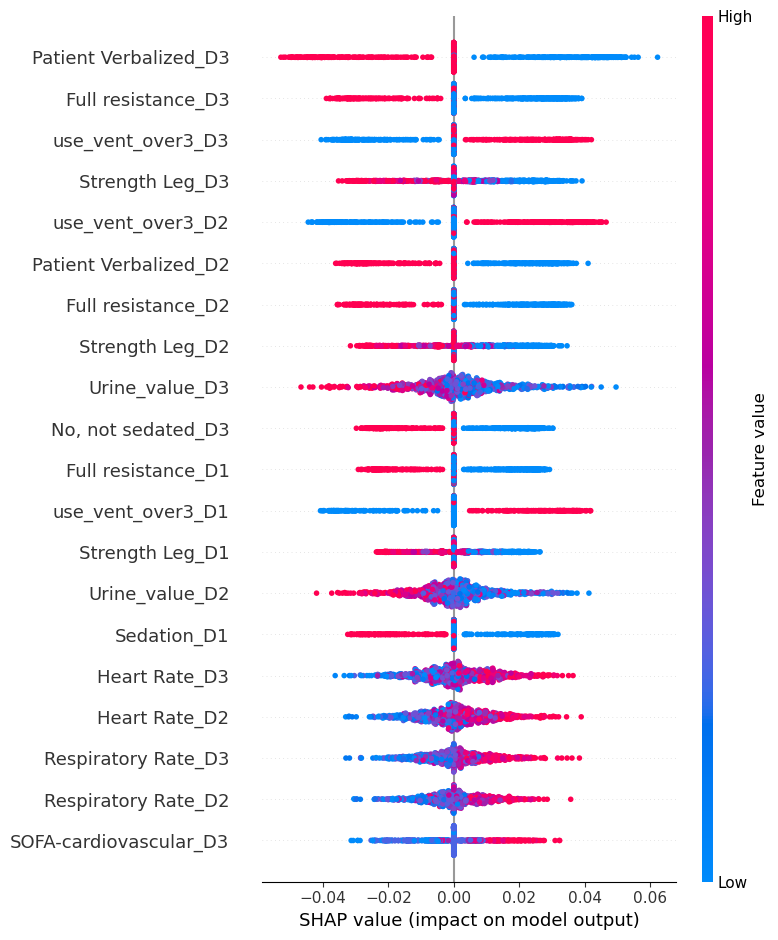

In [20]:
#Sumarry plot
for task_name in task_name_list:
    if task_name == 'DNR':
        shap_value = shap_dict[task_name]['shap_value']
        shap_data = shap_dict[task_name]['shap_data']
        print(shap_value.shape)
        print(f'Task: {task_name}')
        show_shap(shap_value, shap_data,full_feature_name_list,task_name = task_name)
        

In [21]:
# # Summary plot
# for task_name in task_name_list:
#     if task_name == 'DNR':
#         if task_name not in shap_dict:
#             print(f"Task '{task_name}' not found in shap_dict.")
#             continue
        
#         shap_value = shap_dict[task_name].get('shap_value')
#         shap_data = shap_dict[task_name].get('shap_data')
        
#         if shap_value is None or shap_data is None:
#             print(f"Missing SHAP values or data for task: {task_name}")
#             continue
        
#         # 檢查 shap_value 和 shap_data 的形狀是否一致
#         if shap_value.shape != shap_data.shape:
#             print(f"Shape mismatch for task '{task_name}': shap_value {shap_value.shape}, shap_data {shap_data.shape}")
#             continue
        
#         print(shap_value.shape)
#         print(f'Task: {task_name}')
        
#         # 呼叫 show_shap 繪製圖表
#         show_shap(shap_value, shap_data, full_feature_name_list, task_name=task_name)

In [22]:
"""
#所有PDP
task_name = 'DNR'
for i in range (len(full_feature_name_list)):
    print(f'Task:{task_name}...ID[{i}]')
    shap.dependence_plot(i, shap_dict[task_name]['shap_value'], shap_dict[task_name]['shap_data'], feature_names=full_feature_name_list, interaction_index=None)
"""

"\n#所有PDP\ntask_name = 'DNR'\nfor i in range (len(full_feature_name_list)):\n    print(f'Task:{task_name}...ID[{i}]')\n    shap.dependence_plot(i, shap_dict[task_name]['shap_value'], shap_dict[task_name]['shap_data'], feature_names=full_feature_name_list, interaction_index=None)\n"

In [23]:
# def pdp_plot(x, y, feature_name, point_color='black'):
#     point_size = 4
#     #plt.figure(figsize=(6,4))
#     fig, ax = plt.subplots(figsize=(6, 6))
#     plt.scatter(x, y, color=point_color,s=point_size)
#     #plt.xlabel(feature_name)
#     plt.xlabel(feature_name, fontsize=26, fontweight='bold', fontfamily='Arial')
#     plt.ylabel('SHAP Value', fontsize=26, fontweight='bold', fontfamily='Arial')
#     plt.tick_params(axis='both', which='both', labelsize=18)
#     plt.legend()
    
#     if feature_name == 'Peak Airway Pressure':
#         plt.xticks([10,13,16,19,22,25], [10,13,16,19,22,25])
#     if feature_name == 'RASS':
#         plt.xticks([-5,-4,-3,-2,-1,0,1,2,3], [-5,-4,-3,-2,-1,0,1,2,3])
#     if feature_name == 'FiO2':
#         plt.xticks([20,40,60,80,100], [20,40,60,80,100])
#     plt.xticks(fontweight='bold')
#     plt.yticks([])
#     plt.legend().set_visible(False)
#     #plt.legend(loc='lower center')
#     #plt.savefig(f'./PDP/{feature_name}.png', bbox_inches = 'tight', dpi=300)
#     plt.show()

# for feature_name in feature_important[:7]:
#     indedx_of_feature = feature_name_list.index(feature_name)
    
#     shap_data,shap_value = data_select(feature_name,shap_data_flatten,shap_value_flatten,indedx_of_feature)

#     print(feature_name)

#     # if feature_name == 'apsiii':
#     #     name = 'APACHE III'
#     # elif feature_name == 'total':
#     #     name = 'Fluid balance'
#     # elif feature_name == 'Nutrition_Enteral_value':
#     #     name = 'Enteral feeding'
#     # else:
#     #     name = feature_name
        
#     pdp_plot(
#         shap_data, 
#         shap_value, 
#         name
#     )

In [24]:
# for feature_name in feature_important[:7]:
#     if feature_name not in feature_name_list:
#         print(f"Warning: '{feature_name}' not found in feature_name_list. Skipping...")
#         continue  # 跳過不存在的特徵名稱

#     indedx_of_feature = feature_name_list.index(feature_name)

#     shap_data, shap_value = data_select(feature_name, shap_data_flatten, shap_value_flatten, indedx_of_feature)

#     print(feature_name)

#     # 繪製 PDP 圖
#     pdp_plot(
#         shap_data,
#         shap_value,
#         feature_name
#     )

In [25]:
for i in range(len(shap_dict['DNR']['feature_important'])):
    print(f"{i+1}....{shap_dict['DNR']['feature_important'][i]}")

1....Patient Verbalized_D3
2....Full resistance_D3
3....use_vent_over3_D3
4....Strength Leg_D3
5....use_vent_over3_D2
6....Patient Verbalized_D2
7....Full resistance_D2
8....Strength Leg_D2
9....Urine_value_D3
10....No, not sedated_D3
11....Full resistance_D1
12....use_vent_over3_D1
13....Strength Leg_D1
14....Urine_value_D2
15....Sedation_D1
16....Heart Rate_D3
17....Heart Rate_D2
18....Respiratory Rate_D3
19....Respiratory Rate_D2
20....SOFA-cardiovascular_D3
21....Patient Verbalized_D1
22....Family Talked to MD_D3
23....Heart Rate_D1
24....BUN_D3
25....Sedation_D2
26....Full code_D1
27....Urine_value_D1
28....Full code_D3
29....Consecutive_Vasopressor_Over3_D3
30....Systemic Mean_D3
31....Respiratory Rate_D1
32....Systemic Diastolic_D3
33....Systemic Systolic_D3
34....Maintain GCS >= 8_D3
35....total_D3
36....No, not sedated_D2
37....Maintain GCS >= 8_D2
38....SOFA-respiration_D1
39....BUN_D2
40....HCO3_D1
41....Full code_D2
42....SOFA-renal_D3
43....Consecutive_avg_FiO2_Over50_D3
4

In [26]:
#各特徵索引
for i in range (len(full_feature_name_list)):
    print(f'[{i}]...{full_feature_name_list[i]}')

[0]...SaO2_D1
[1]...SaO2_D2
[2]...SaO2_D3
[3]...Heart Rate_D1
[4]...Heart Rate_D2
[5]...Heart Rate_D3
[6]...Systemic Systolic_D1
[7]...Systemic Systolic_D2
[8]...Systemic Systolic_D3
[9]...Systemic Diastolic_D1
[10]...Systemic Diastolic_D2
[11]...Systemic Diastolic_D3
[12]...Systemic Mean_D1
[13]...Systemic Mean_D2
[14]...Systemic Mean_D3
[15]...Consecutive_avg_FiO2_Over50_D1
[16]...Consecutive_avg_FiO2_Over50_D2
[17]...Consecutive_avg_FiO2_Over50_D3
[18]...Consecutive_Vasopressor_Over7_D1
[19]...Consecutive_Vasopressor_Over7_D2
[20]...Consecutive_Vasopressor_Over7_D3
[21]...Consecutive_Vasopressor_Over3_D1
[22]...Consecutive_Vasopressor_Over3_D2
[23]...Consecutive_Vasopressor_Over3_D3
[24]...Consecutive_avg_FiO2_Over60_D1
[25]...Consecutive_avg_FiO2_Over60_D2
[26]...Consecutive_avg_FiO2_Over60_D3
[27]...Full_code_interval_D1
[28]...Full_code_interval_D2
[29]...Full_code_interval_D3
[30]...Strength Arm_D1
[31]...Strength Arm_D2
[32]...Strength Arm_D3
[33]...Strength Leg_D1
[34]...Stren

In [27]:
"""
輸入索引查詢對應PDP
"""
choose_feature_index = int(input())
shap.dependence_plot(choose_feature_index, shap_dict[task_name]['shap_value'], shap_dict[task_name]['shap_data'], feature_names=full_feature_name_list, interaction_index=None)

ValueError: invalid literal for int() with base 10: ''

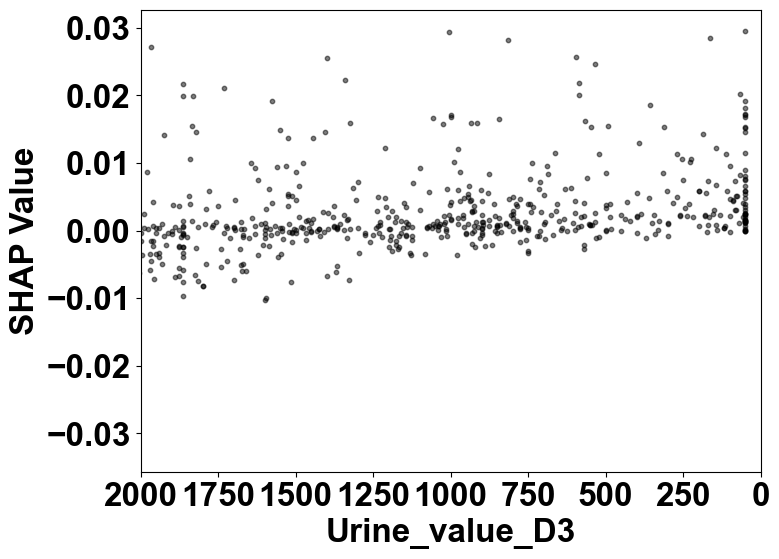

In [35]:
#PDP反轉，黑白版
import shap
import matplotlib.pyplot as plt
import numpy as np

# 字體屬性設定
font_properties = {'size': 24, 'family': 'Arial', 'fontweight': 'bold'}

choose_feature_index = int(input("請輸入特徵索引："))

# 提取對應的特徵值和 SHAP 值
feature_values = shap_dict[task_name]['shap_data'][:, choose_feature_index]
shap_values = shap_dict[task_name]['shap_value'][:, choose_feature_index]

# 根據特徵值進行降序排序
sorted_indices = np.argsort(feature_values)[::-1]  # 降序排序
sorted_feature_values = feature_values[sorted_indices]
sorted_shap_values = shap_values[sorted_indices]

# 繪製 SHAP 依賴圖（反轉 X 軸）
plt.figure(figsize=(8, 6))
plt.scatter(sorted_feature_values, sorted_shap_values, alpha=0.5, color='black', s=10)
#plt.gca().set_xlim(max(feature_values), min(feature_values))  # 設定 X 軸範圍為降序
plt.gca().set_xlim(2000, 0, 500)  # 設定 X 軸範圍為 0~2000，並反轉

plt.xlabel(full_feature_name_list[choose_feature_index], fontsize=font_properties['size'], 
           fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
plt.ylabel(f"SHAP Value", fontsize=font_properties['size'], 
           fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
plt.xticks(fontsize=font_properties['size'], fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
plt.yticks(fontsize=font_properties['size'], fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
plt.show()

#Urine_value_D3 = 158

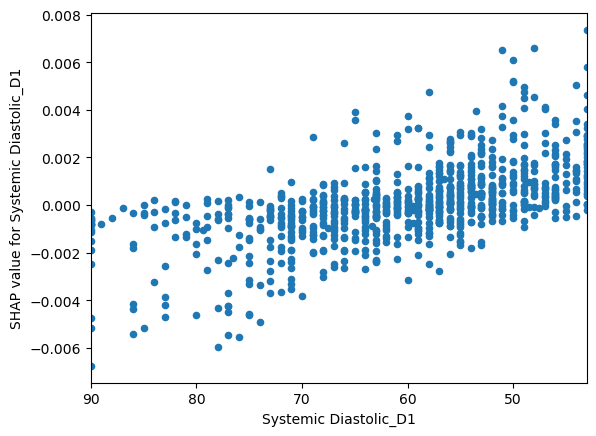

In [30]:
#PDP圖反轉
import shap
import matplotlib.pyplot as plt

choose_feature_index = int(input())

# 提取對應的特徵值和 SHAP 值
feature_values = shap_dict[task_name]['shap_data'][:, choose_feature_index]
shap_values = shap_dict[task_name]['shap_value'][:, choose_feature_index]

# 根據特徵值進行降序排序
sorted_indices = np.argsort(feature_values)[::-1]  # 降序排序
sorted_feature_values = feature_values[sorted_indices]
sorted_shap_values = shap_values[sorted_indices]

# 繪製 SHAP 依賴圖（反轉 X 軸）
plt.scatter(sorted_feature_values, sorted_shap_values, s=20)
plt.gca().set_xlim(max(feature_values), min(feature_values))  # 設定 X 軸範圍為降序
plt.xlabel(full_feature_name_list[choose_feature_index])
plt.ylabel(f'SHAP value for {full_feature_name_list[choose_feature_index]}')
plt.show()

In [ ]:
for i in range (len(full_feature_name_list)):
    if full_feature_name_list[i] in shap_dict[task_name]['feature_important'][:20]:
        print(f'Task:{task_name}...ID[{i}]')
        #shap.dependence_plot(i, shap_dict[task_name]['shap_value'], shap_dict[task_name]['shap_data'], feature_names=full_feature_name_list, interaction_index=None)
        shap.dependence_plot(i, shap_dict[task_name]['shap_value'], shap_dict[task_name]['shap_data'], feature_names=full_feature_name_list, interaction_index=None)
        

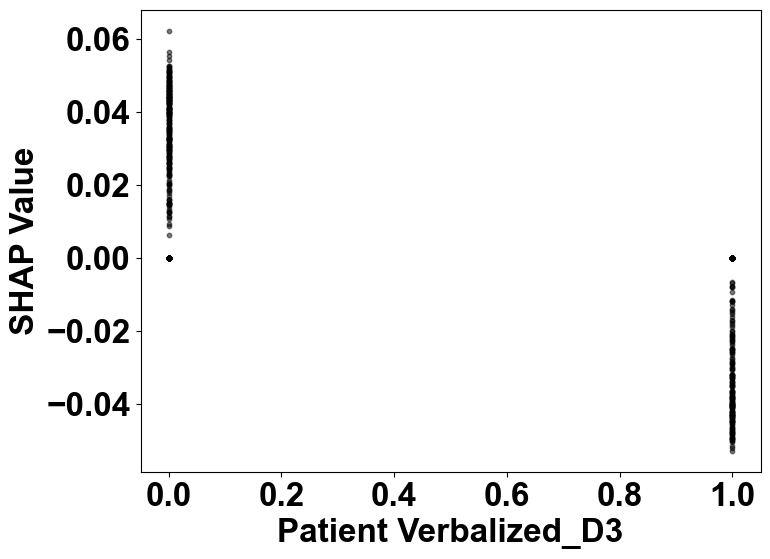

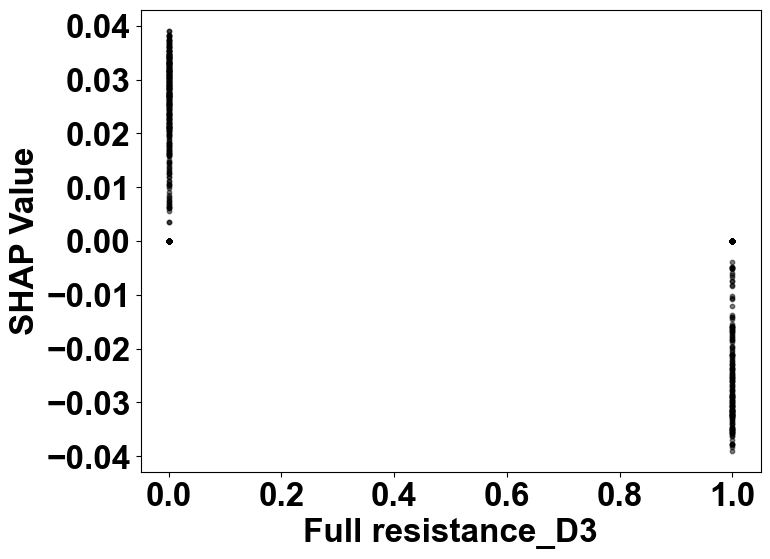

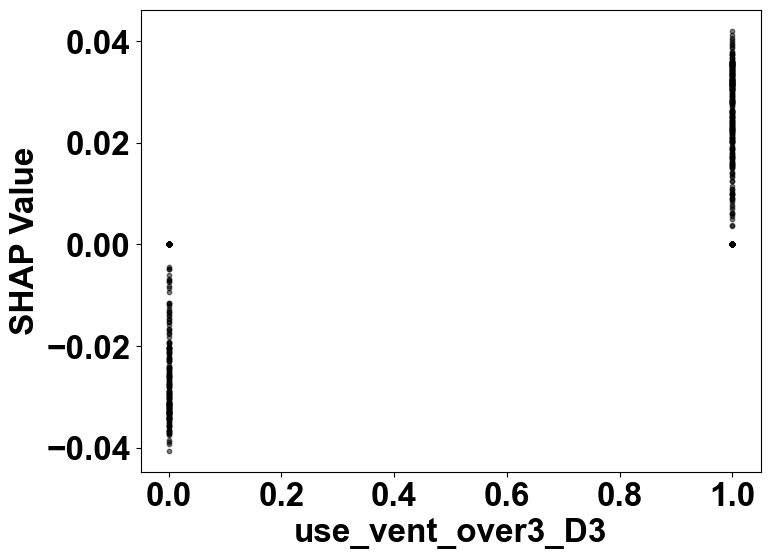

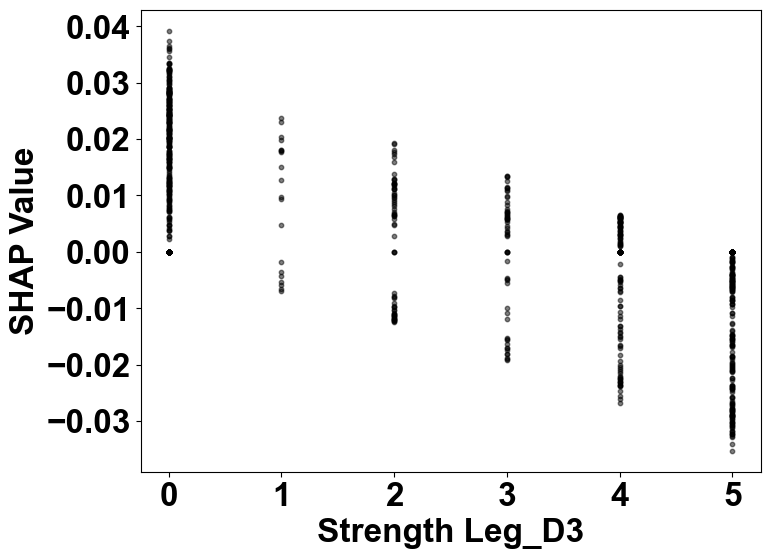

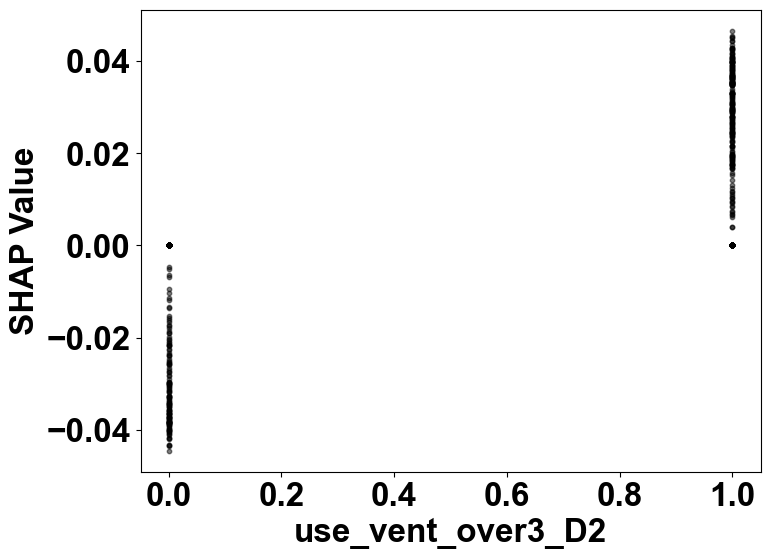

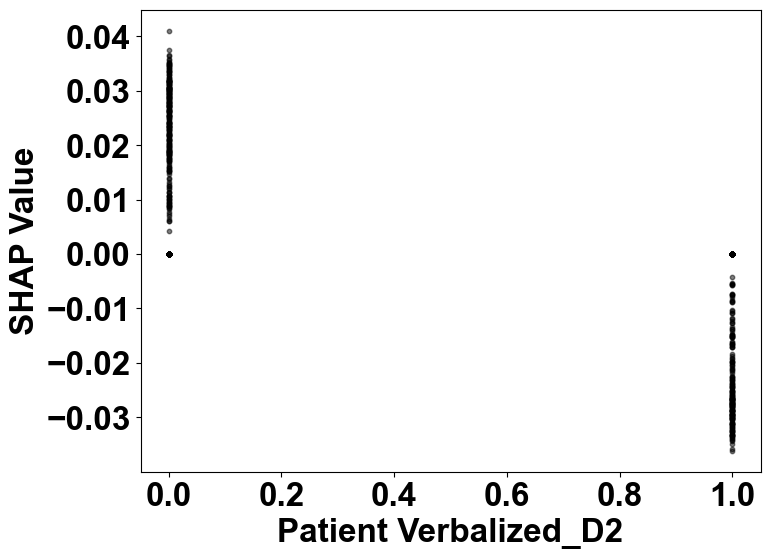

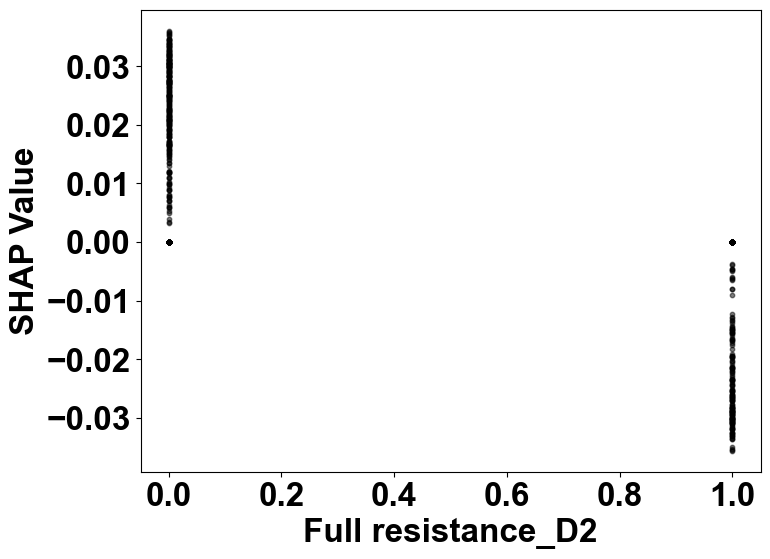

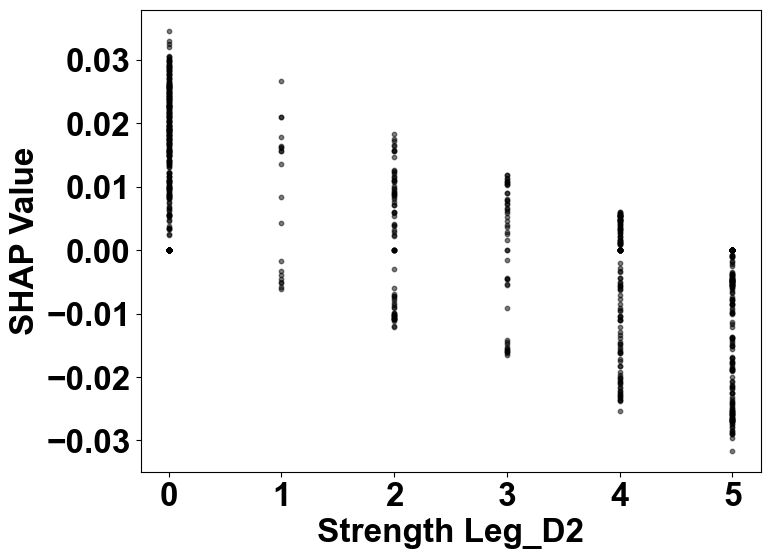

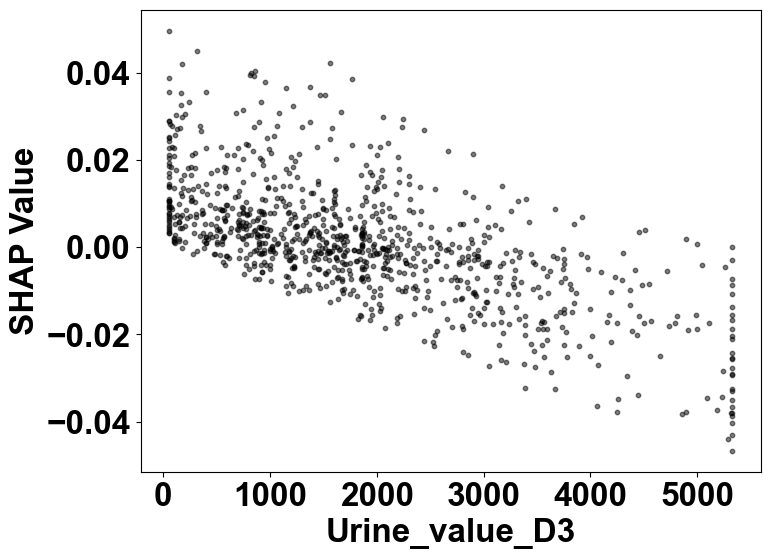

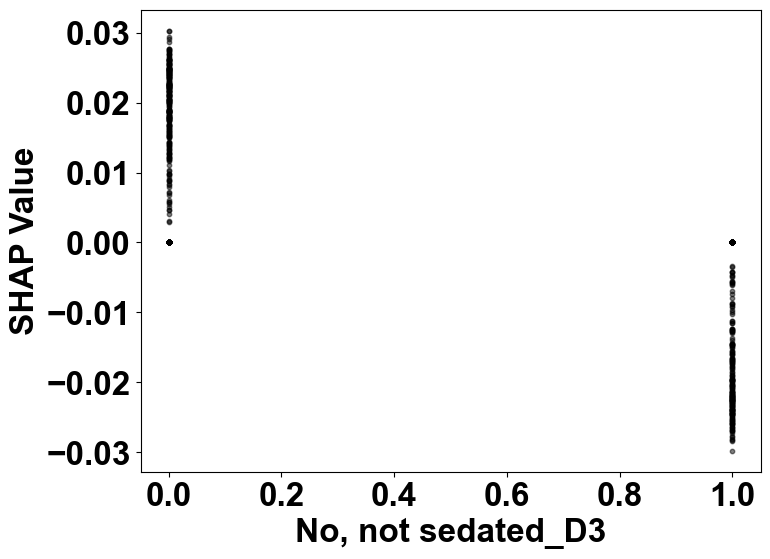

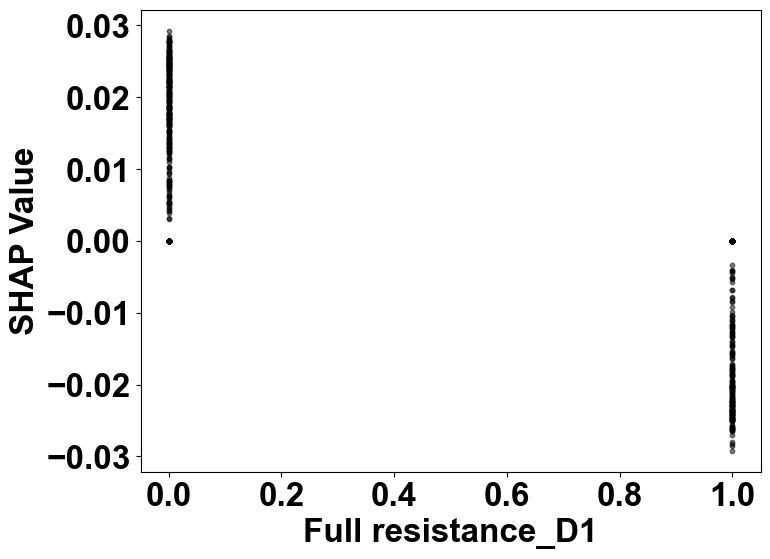

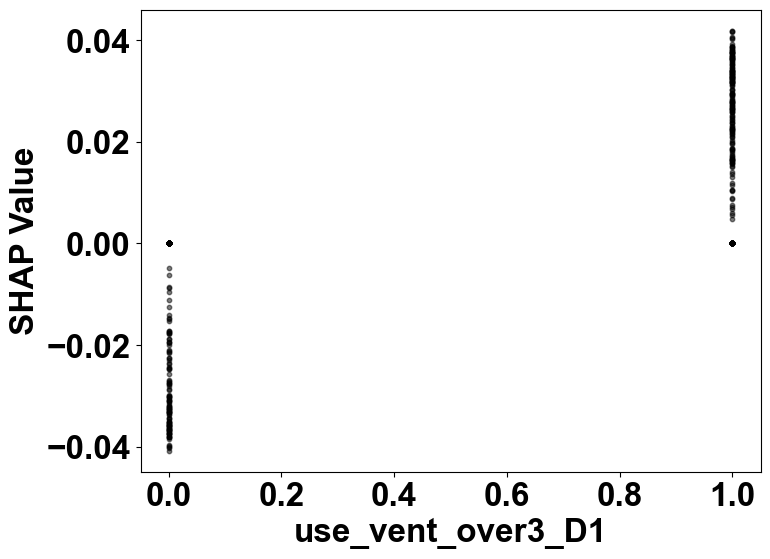

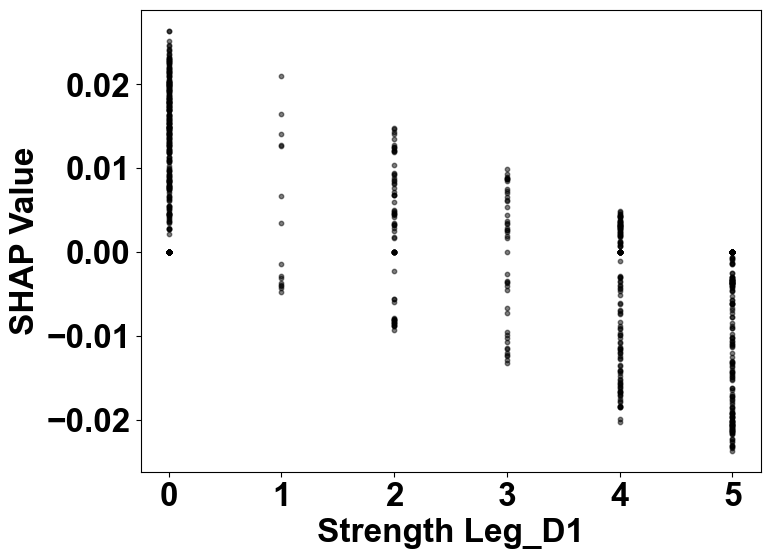

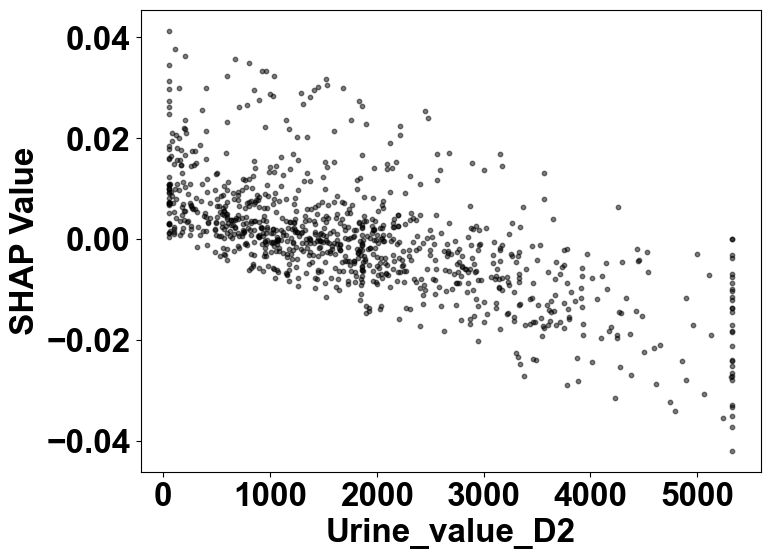

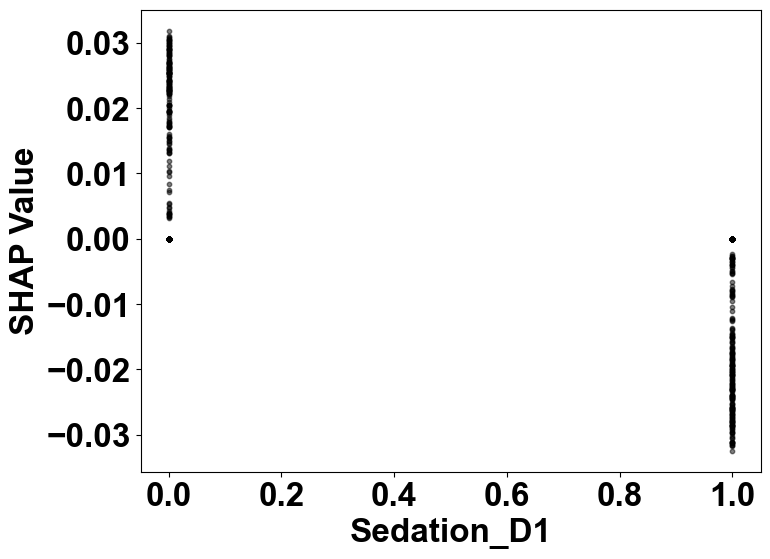

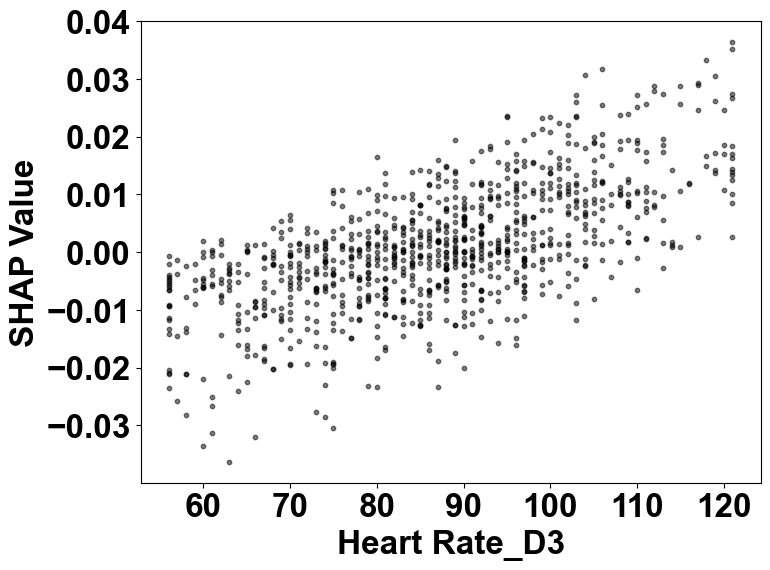

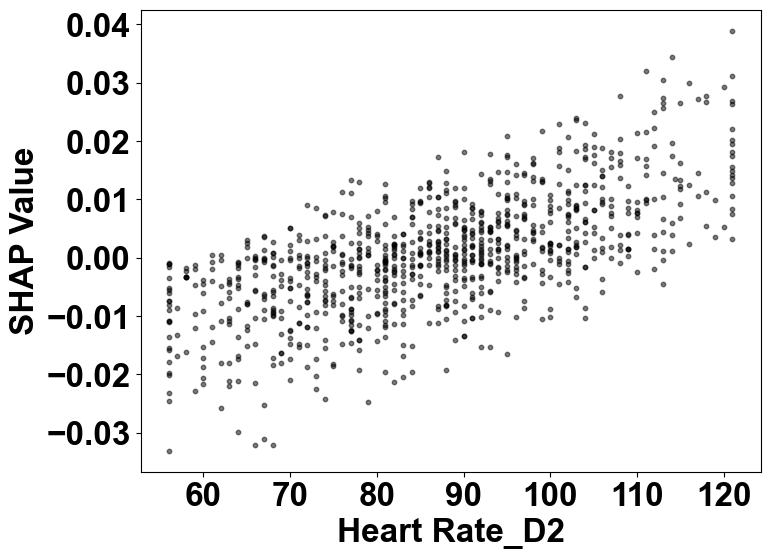

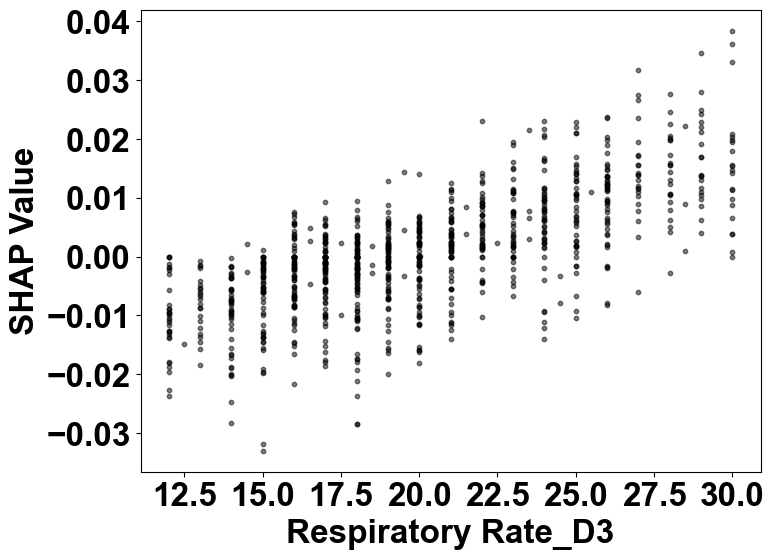

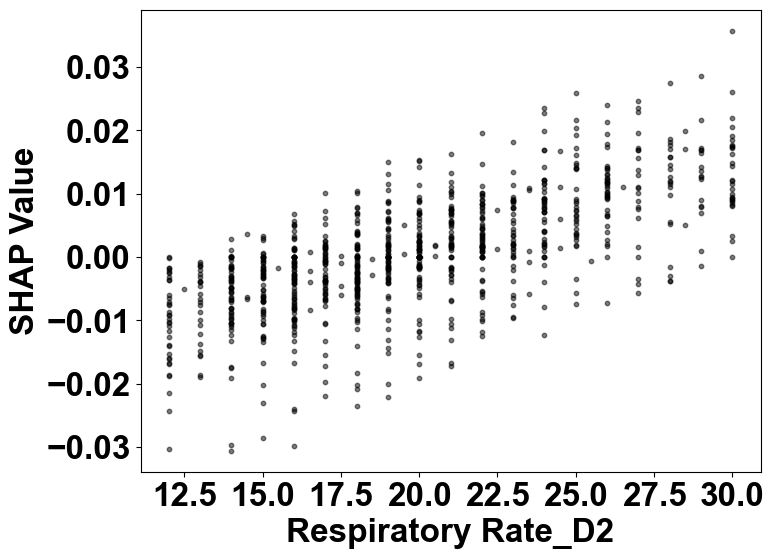

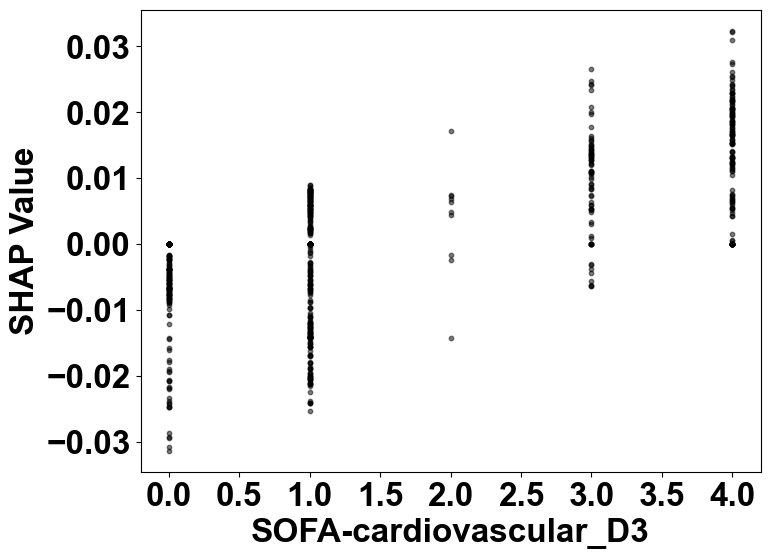

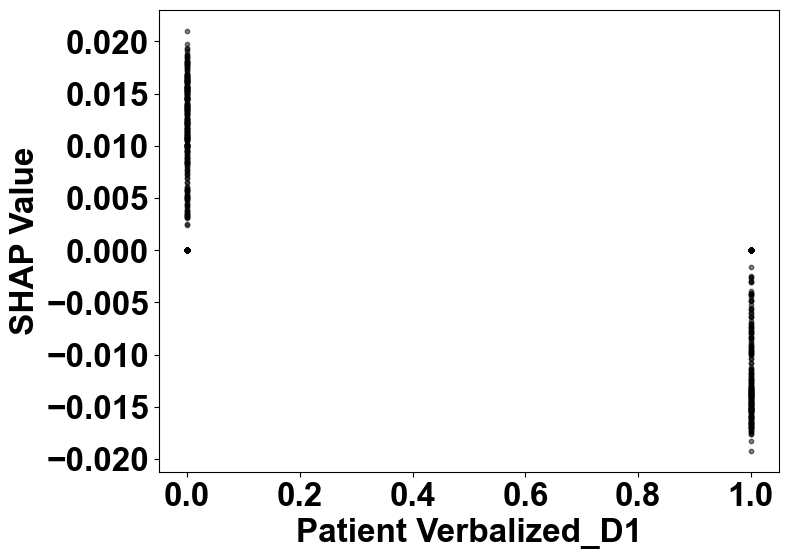

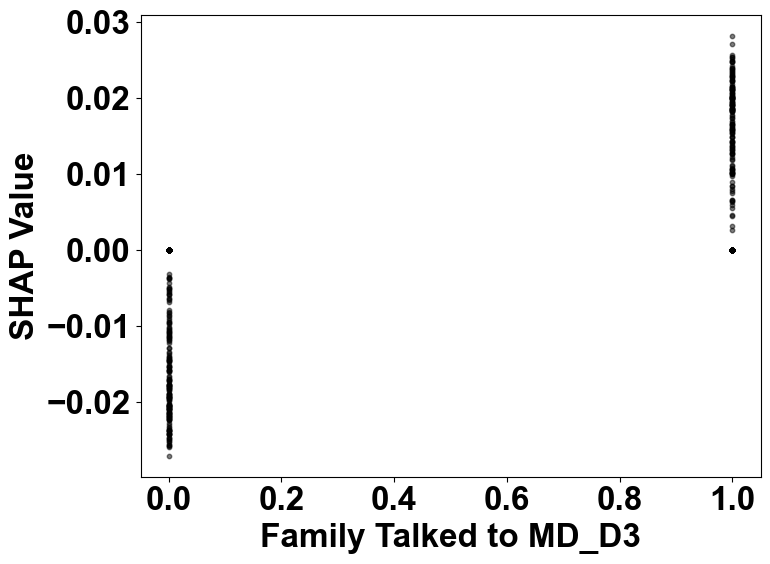

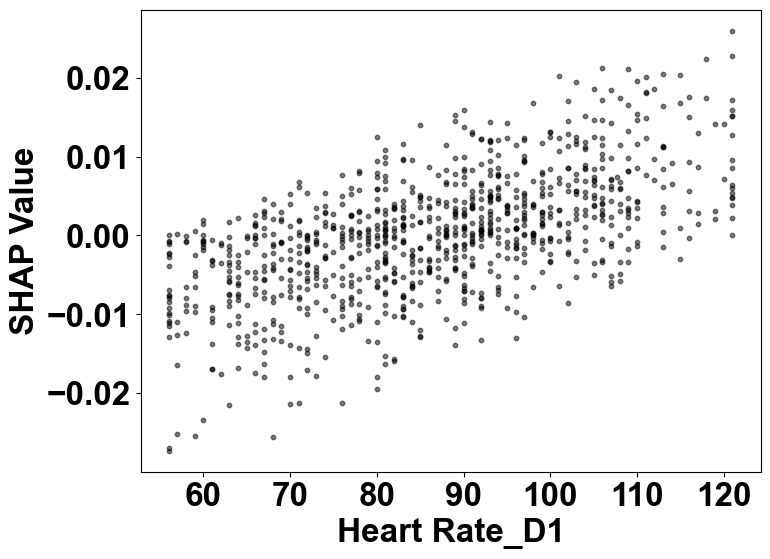

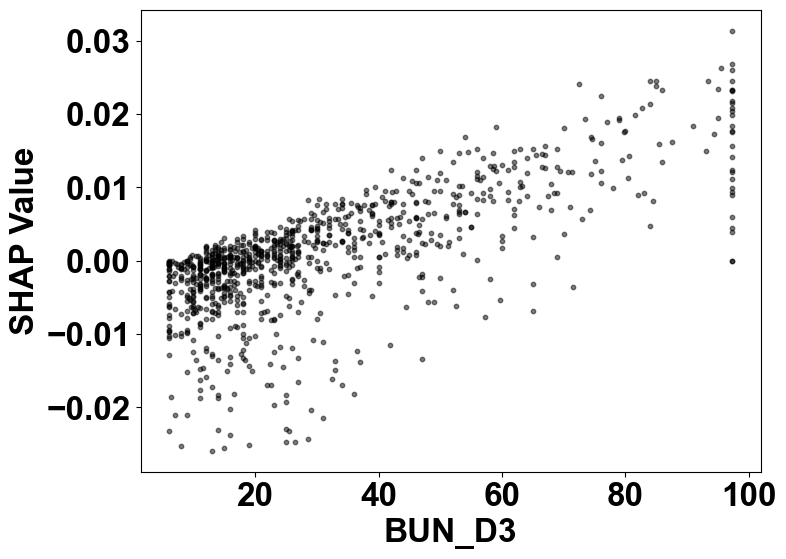

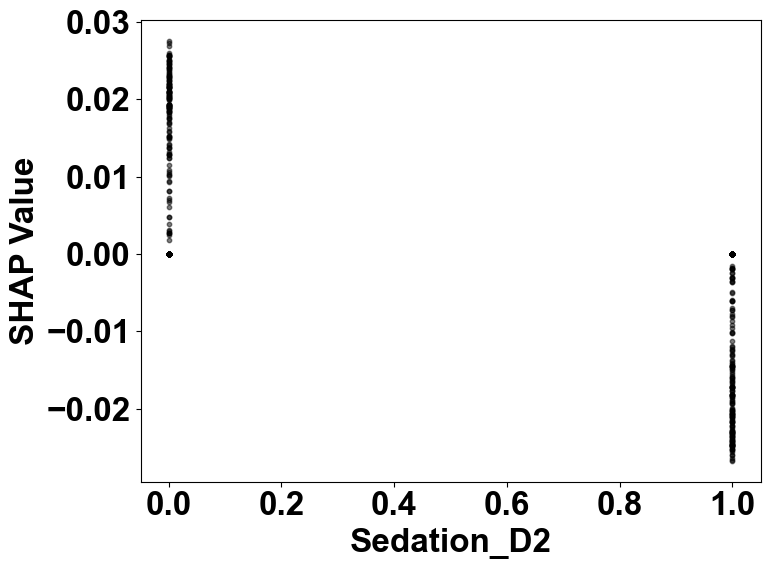

In [29]:
#前20個PDP，黑白版
import shap
import matplotlib.pyplot as plt
import numpy as np

def plot_pdp(task_name, shap_dict, full_feature_name_list, top_k=10):
    """
    繪製指定任務的前 K 個重要特徵的部分依賴圖 (PDP)。

    Args:
        task_name (str): 任務名稱。
        shap_dict (dict): 包含 SHAP 值和相關數據的字典。
        full_feature_name_list (list): 完整的特徵名稱列表。
        top_k (int): 要繪製的前 K 個重要特徵數量。
    """
    # 確保 task_name 存在於 shap_dict 中
    if task_name not in shap_dict:
        print(f"Task '{task_name}' not found in shap_dict.")
        return

    # 獲取該任務的前 K 個重要特徵
    top_features = shap_dict[task_name]['feature_important'][:top_k]

    font_properties = {'size': 24, 'family': 'Arial', 'fontweight': 'bold'}

    for feature_name in top_features:
        feature_index = full_feature_name_list.index(feature_name)
        shap_values = shap_dict[task_name]['shap_value'][:, feature_index]
        feature_values = shap_dict[task_name]['shap_data'][:, feature_index]

        # 繪製 PDP
        plt.figure(figsize=(8, 6))
        plt.scatter(feature_values, shap_values, alpha=0.5, color='black', s=10)
        plt.xlabel(feature_name, fontsize=font_properties['size'], fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
        plt.ylabel('SHAP Value', fontsize=font_properties['size'], fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
        plt.xticks(fontsize=font_properties['size'], fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
        plt.yticks(fontsize=font_properties['size'], fontweight=font_properties['fontweight'], fontfamily=font_properties['family'])
        #plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# 使用範例
plot_pdp(task_name='DNR', shap_dict=shap_dict, full_feature_name_list=full_feature_name_list, top_k=25)

# Feature Important

In [ ]:
#df_full_feature_name_with_category = pd.read_csv('./data/sample/full_feature_name_with_category.csv')

df_full_feature_name_with_category = pd.read_csv('C:/Users/USER/M1326168/MIMIC/DNR/20250507/data/sample/full_feature_name_with_category.csv')
print(df_full_feature_name_with_category)

In [ ]:
# 將相同 category 的值相加
result = {}
for key, value in shap_dict['DNR']['feature_important_dict'].items():
    for index, row in df_full_feature_name_with_category.iterrows():
        if key.startswith(row['feature_name']):
            category = row['category']
            if category not in result:
                result[category] = 0
            result[category] += value
            break
#轉百分比
total_sum = sum(result.values())
result_percentage = {category: (value / total_sum) * 100 for category, value in result.items()}
#print(result_percentage)
plt.figure(figsize=(15, 6))
plt.bar(list(result_percentage.keys()), list(result_percentage.values()))
plt.xlabel('Category')
plt.ylabel('Feature Important(%)')
#plt.title('Sum of Values by Category')
plt.show()

In [ ]:
group_important_dict = {}
for feature_name in feature_name_list:
    total_importance = 0
    for key, value in shap_dict['DNR']['feature_important_dict'].items():
        if key.startswith(feature_name):
            total_importance += value
    group_important_dict[feature_name] = total_importance


In [ ]:
# 依重要度排序
top_k = 15
sorted_group_important_dict = dict(sorted(group_important_dict.items(), key=lambda x: x[1], reverse=True))

# 繪製重要度圖
top_features = list(sorted_group_important_dict.keys())[:top_k]
top_importance = [sorted_group_important_dict[feature] for feature in top_features]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_k} Feature Importance')
plt.gca().invert_yaxis()  # 使得重要度高的特徵在上方
plt.show()